<a href="https://colab.research.google.com/github/pavalos6401/CSCI-493/blob/main/ipynb/intro_to_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to TensorFlow

## Sources

Many of the definitions are taken from this
[cheatsheet](https://ml-cheatsheet.readthedocs.io/en/latest).

## Prerequisites

### Python

You can download the Python installer from their [downloads page](https://www.python.org/downloads/).

The typical installation of Python includes the Package Installer for Python (pip). This tool will allow you to install TensorFlow, among other useful packages.

In this notebook, Python is pre-installed, and pip is not needed.

### Packages

You will need the `tensorflow` package.

More often than not, you'll also need `numpy` (mathematics and arrays) and `matplotlib` (graphs, plots, etc.).

#### Installation

For Windows, you will probably need to run the following (unless you've added
`pip` to `PATH`):
```commandline
$ python -m pip install tensorflow numpy matplotlib
```

On MacOS or Linux, you can use:
```commandline
$ pip install tensorflow numpy matplotlib
```

Within this notebook, the installation set can be skipped.

## Imports

To begin using TensorFlow, you need to import it into your file(s) that use it.
Similarly, import any other packages you're using.

In [ ]:
# It's common practice in python to shorten long package names
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

# (optional) What version of tensorflow is being used
print(tf.__version__)

2.6.0


### Dataset

In this case, I'm importing the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), which consists of images of the 10 digits.

The images are of size 28x28, and the pixels' values range from 0 through 255 (grayscale).

This dataset is included with the `tensorflow` package.

To clean the data, it's best to convert the grayscale images from using integers (0 through 255) to using floating-point numbers (0 through 1).

This "normalizes" the values. It is not necessary, but it is recommended. Think of it like simplifying vectors (which is what we're doing).

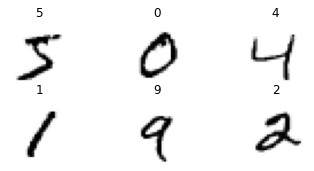

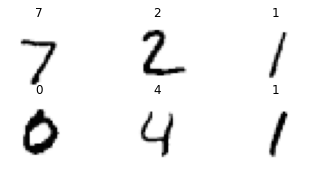

In [ ]:
# Store the namespace into a variable
mnist = tf.keras.datasets.mnist

# Retrieve the training and testing sets.
#   x refers to the images in this case;
#   y refers to the digit that the image represents.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# The size of the image is 28x28
input_shape = (28, 28)

# Divide by 255 (and make sure they're floating point numbers)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Display some images in the training set.
plt.figure()
for i in range(0, 6):
  plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i], cmap="Greys")
  plt.title(y_train[i])
  plt.axis("off")

# Display some images in the testing set.
plt.figure()
for i in range(0, 6):
  plt.subplot(3, 3, i + 1)
  plt.imshow(x_test[i], cmap="Greys")
  plt.title(y_test[i])
  plt.axis("off")

## Building the Model

Now we build the training model.

### Layers

In this case we're using a Sequential model because we only have
one input tensor and one output tensor in each layer.

1. Flatten: This converts the 28x28 image into a 1D array for the algorithm
to process
2. Dense: This is basically the "standard" layer and it's used to change the size/dimension of the vector/array. This layer can have any output size, in this case 128 is selected to keep it from taking too long and avoiding "overfitting".
3. Dropout: This helps avoid "overfitting" by dropping random neurons.
4. Dense: This last layer reduces the tensor (vector/array) to a size of 10,
this means that it will reduce it to the array of size 10 -- this final
result is a logit, as explained in the next section

- Dense layer
: The neurons are all deeply connected

- Neuron
: Takes a group of weighted inputs and applies an activation function,
returns an output

- Overfitting
: When the model fits exactly to the training set
: This is bad for data outside the training set

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_shape),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Predictions

The model returns a vector of "logits" or "log-odds" scores.

- logits
: Vector of raw predictions that a classification model generates.
- log-odds
: Logarithm of the odds of some event.

For example, these are the results for the first picture in the training set.

(Keep in mind that the model has not been trained, so the results should be
"random")

In [ ]:
def predict(a: np.ndarray) -> np.ndarray:
  """Find the logits for a given array.

  params:
    a (np.ndarray): Array to run the predictions on.

  returns:
    An array (np.ndarray) representing the logits.
  """
  return model(a).numpy()

predictions = predict(x_train[:1])
predictions

array([[ 0.5800774 ,  0.56801   , -0.48327026, -0.44113064,  0.12097763,
        -0.03140879,  0.6055083 ,  1.0329595 , -0.11873405, -0.01364875]],
      dtype=float32)

The `softmax` function converts the above values to probabilities.

In [ ]:
def to_probs(a: np.ndarray) -> np.ndarray:
  """Converts an array (logits) to an array of probabilities.

  params:
    a (np.ndarray): Logits array

  returns:
    An array (np.ndarray) of the probabilities for each index.
  """
  return tf.nn.softmax(a).numpy()

probabilities = to_probs(predictions)
probabilities

array([[0.13305134, 0.1314554 , 0.04594235, 0.04791972, 0.08406878,
        0.07218619, 0.13647835, 0.20926829, 0.06614992, 0.07347967]],
      dtype=float32)

Then, the index with the greatest probability is the one that the model has
selected as the most probable answer, so find the maximum value in the array.

As you can see below, the machine is guessing wrong, since it's not trained yet.

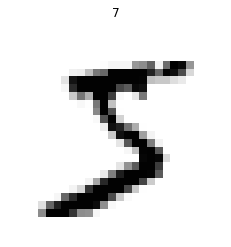

In [ ]:
plt.title(probabilities.argmax())
plt.axis("off")
plt.imshow(x_train[0] , cmap="Greys")

#### Loss

The following takes a vector of logits and a `True` index and returns a scalar
loss for each example

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Loss is equal to the negative log probability of the true class.

Zero means that the model is sure of the correct classification.

Currently, the model has not been trained, so the probabilities are "random".
In reality they should be close to $-ln(\frac{1}{10})$.

In [ ]:
print(loss_fn(y_train[:1], predictions).numpy())
print(-tf.math.log(1/10))

2.6285064
tf.Tensor(2.3025851, shape=(), dtype=float32)


### Compilation

This creates the settings for the training.

- Optimizer
: The selection of a best element, with regard to some criterion, from some set
of available alternatives
: [visualization](https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html)
: [valid inputs](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
- Loss
: Loss function, as defined above.
- Metrics
: "accuracy" - how often the prediction matches the label

In [ ]:
model.compile(
  optimizer="adam",
  loss=loss_fn,
  metrics=["accuracy"]
)

## Training

Now, all that's left is to train (fit) the model using the training set.

In this case, we want to train the model for 5 epochs.
To avoid overfitting, you don't want to choose a large value for the epochs,
but you also don't want too small a value because that leads to underfitting.
The number of epochs will depend on the size of the training dataset.

- epoch
: The number of passes of the entire training dataset the machine learning
algorithm has completed

In [ ]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2974 - accuracy: 0.9137
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1415 - accuracy: 0.9580
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1082 - accuracy: 0.9667
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0899 - accuracy: 0.9723
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0764 - accuracy: 0.9759


## Results

In [ ]:
model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 1s 1ms/step - loss: 0.0804 - accuracy: 0.9761


[0.08040975034236908, 0.9761000275611877]

To illustrate those accuracies, the following piece of code will take 100
elements, starting at a random index, and plot them, displaying the guess
and the true answer. When the model guesses wrong, the image will be displayed
as red.

Starting at 1871
accuracy: 0.97


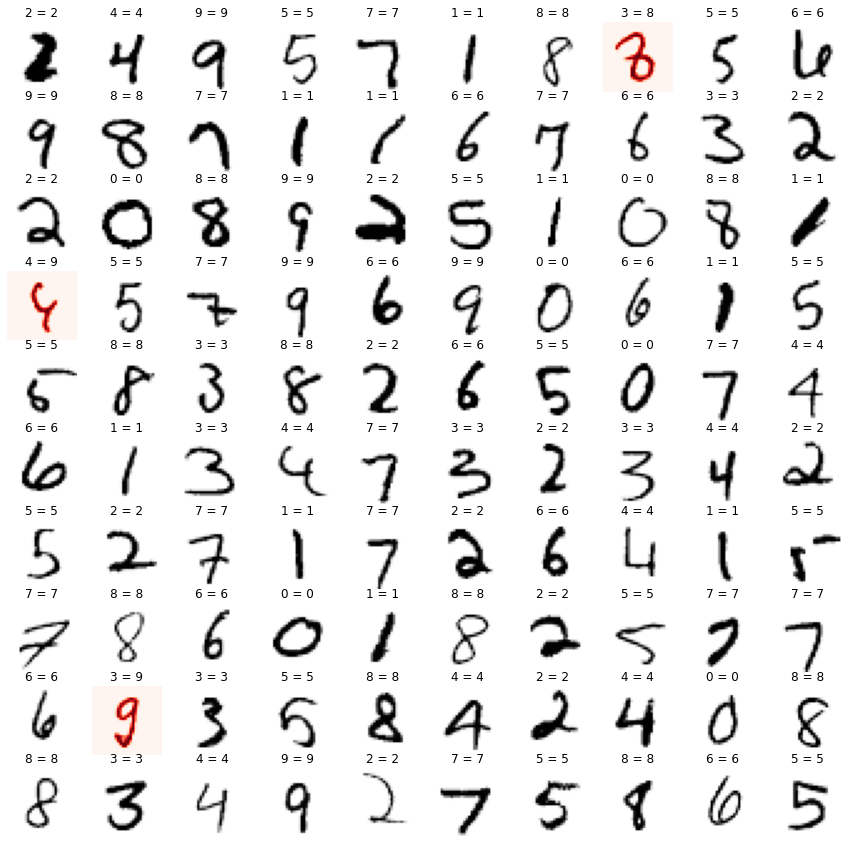

In [ ]:
import random
start = random.randrange(0, y_test.size - 100)
print(f"Starting at {start}")
wrong = 0

plt.figure(figsize=(15, 15))
for pos, i in enumerate(range(start, start + 100)):
  # Run the model on a single image.
  logits = predict(x_test[i : i + 1])
  # Convert the logits to probabilities as seen before.
  probs = to_probs(logits)
  # Then find the index with the maximum value (what is most likely).
  guess = probs.argmax()

  # Display the image and the title as "guess = actual"
  plt.subplot(10, 10, pos + 1)
  plt.title(f"{guess} = {y_test[i]}")
  if (guess == y_test[i]):
    plt.imshow(np.squeeze(x_test[i]), cmap="Greys")
  else:
    plt.imshow(np.squeeze(x_test[i]), cmap="Reds")
    wrong += 1
  plt.axis("off")

# Print the accuracy of this small sample
print(f"accuracy: {1 - (wrong / 100)}")